# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler

import warnings
from itertools import product

from statsmodels.tools.eval_measures import rmse

# Đọc dữ liệu

In [2]:
df = pd.read_csv('cleaned_integrated_stock_data.csv')

Số cổ phiếu trong dataset đã tiền xử lý để dự đoán giá

In [3]:
unique_names = df['Name'].unique().tolist()
len(unique_names)

2836

In [4]:
if df['date'].dtype == 'object':
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['Current price'] = pd.to_numeric(df['Current price'], errors='coerce')
df = df.sort_values(by='date').reset_index(drop=True)
df

,Name,Current price,Open,High,Low,Volume,date
0,VISIONARY HOLDINGS INC.,2.510,2.280,2.850,2.1700,24468952.0,2025-03-05
1,INNOSPEC INC.,98.090,97.770,98.740,97.1300,3510.0,2025-03-05
2,22ND CENTURY GROUP INC,1.970,1.900,1.970,1.9000,3502.0,2025-03-05
3,EMBECTA CORP.,12.710,12.570,12.760,12.4200,3476.0,2025-03-05
4,TECTONIC THERAPEUTIC INC.,23.680,23.350,23.840,23.2000,3475.0,2025-03-05
...,...,...,...,...,...,...,...
280759,FLUSHING FINANCIAL,12.420,12.490,12.490,12.4000,2815.0,2025-06-11
280760,FLYWIRE CORP.,10.860,10.480,10.900,10.4200,374196.0,2025-06-11
280761,FOCUS UNIVERSAL INC.,3.830,3.830,3.830,3.8300,157.0,2025-06-11
280762,FRANKLIN ELECTRIC CO. INC.,87.630,87.890,88.380,87.3200,5889.0,2025-06-11


# Mô hình hóa dữ liệu

Chọn ra 1 cổ phiếu và giá trị close của nó theo hằng ngày

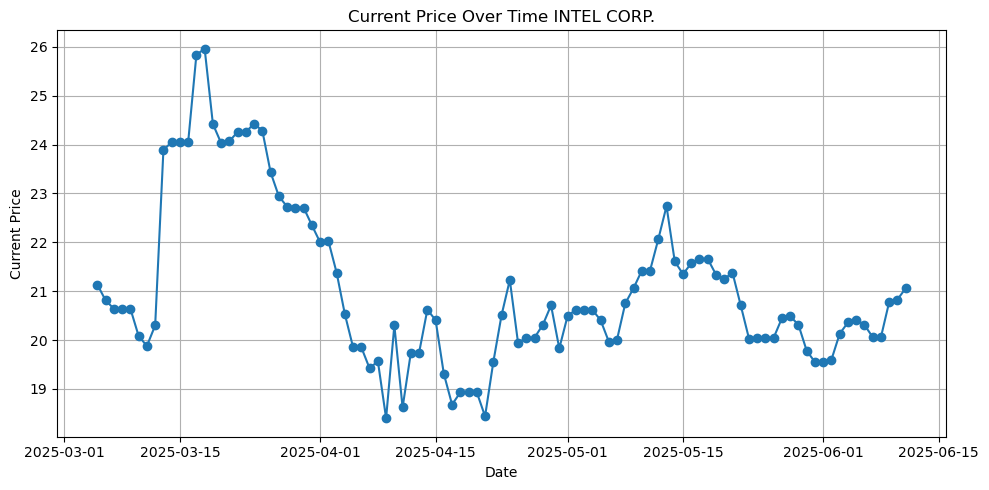

In [5]:
name = 'INTEL CORP.'
filtered_df = df[df['Name'] == name][['date', 'Current price']].reset_index(drop=True)
filtered_df = filtered_df.set_index('date')
#filtered_df.index += 1
plt.figure(figsize=(10, 5))
plt.plot( filtered_df['Current price'], marker='o', linestyle='-')
plt.title('Current Price Over Time ' + name)
plt.xlabel('Date')
plt.ylabel('Current Price')
plt.grid(True)
plt.tight_layout()
plt.show()

Dữ liệu trực quan như trên là tầm hơn 90 ngày. Chúng ta muốn dự đoán cổ phiếu theo kỳ hạn 10 ngày. Để kiểm tra hiệu suất của 1 mô hình dự đoán, ta cho 10 ngày cuối cùng là tập test. Còn lại là tập train.

In [6]:
train = filtered_df.iloc[:len(filtered_df)-10]
test = filtered_df.iloc[len(filtered_df)-10:]

## Lựa chọn mô hình

- Mô hình thống kê (truyền thống): ARIMA
- Mô hình học sâu (hiện đại): LSTM

### ARIMA

Cấu hình mô hình và tìm ra bộ tham số tốt nhất

In [7]:
warnings.filterwarnings("ignore")

p_values = range(1, 3)  # Define the range for ARIMA(p,d,q)
d_values = range(0, 2)
q_values = range(2, 5)
s_values = [5, 7, 10, 15]

min_rmse = 1e9
start = len(train)
end = len(train) + len(test) - 1

for p, d, q, s in product(p_values, d_values, q_values, s_values):
    model = SARIMAX(train['Current price'],
                order = (0, 1, 3),
                seasonal_order =(p, d, q, s))

    result = model.fit()
    predictions = result.predict(start, end).rename("Predictions")

    cur_rmse = rmse(test["Current price"], predictions)

    if cur_rmse < min_rmse:
        min_rmse = cur_rmse
        best_params = (p, d, q, s)

In [12]:
warnings.filterwarnings("ignore")

model = SARIMAX(train['Current price'],
                order = (0, 1, 3),
                seasonal_order = best_params)

result = model.fit()

Trực quan hóa kết quả dự đoán.

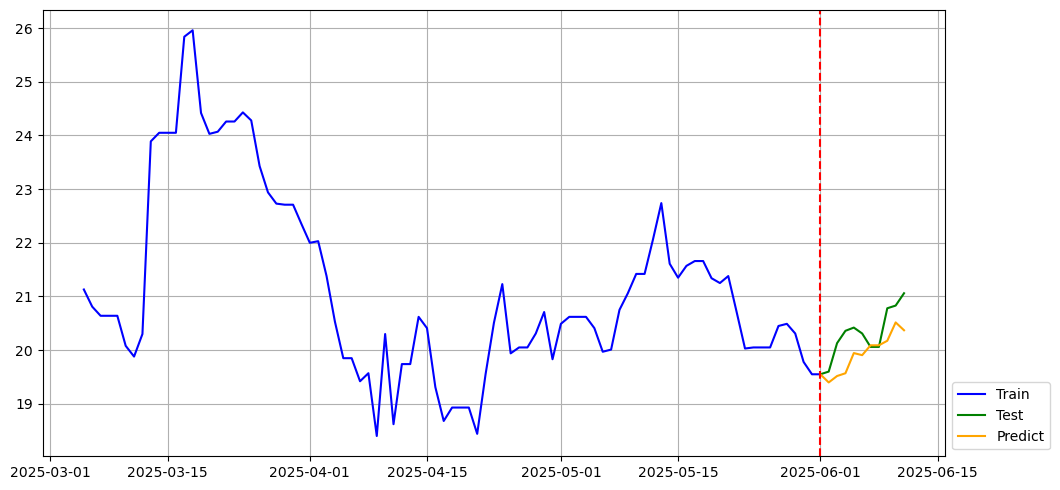

In [13]:
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end).rename("Predictions")

# plot predictions and actual values
prepended_value = pd.Series([train['Current price'].iloc[-1]], index=[train.index[-1]])
test_series = pd.concat([prepended_value, test['Current price']])
predictions = pd.concat([prepended_value, predictions])

plt.figure(figsize=(10, 5))
plt.plot(train['Current price'], marker='', linestyle='-', color = 'blue', label = 'Train')
plt.plot(test_series, marker='', linestyle='-', color = 'green', label = 'Test')
plt.plot(predictions, marker='', linestyle='-', color = 'orange', label = 'Predict')
plt.axvline(x=train.index[-1], color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

Tính toán độ lỗi RMSE cho tập test.

In [14]:
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse_loss = rmse(test_series, predictions)
print("Root mean squared error: ", rmse_loss)

Root mean squared error:  0.4644426142517835


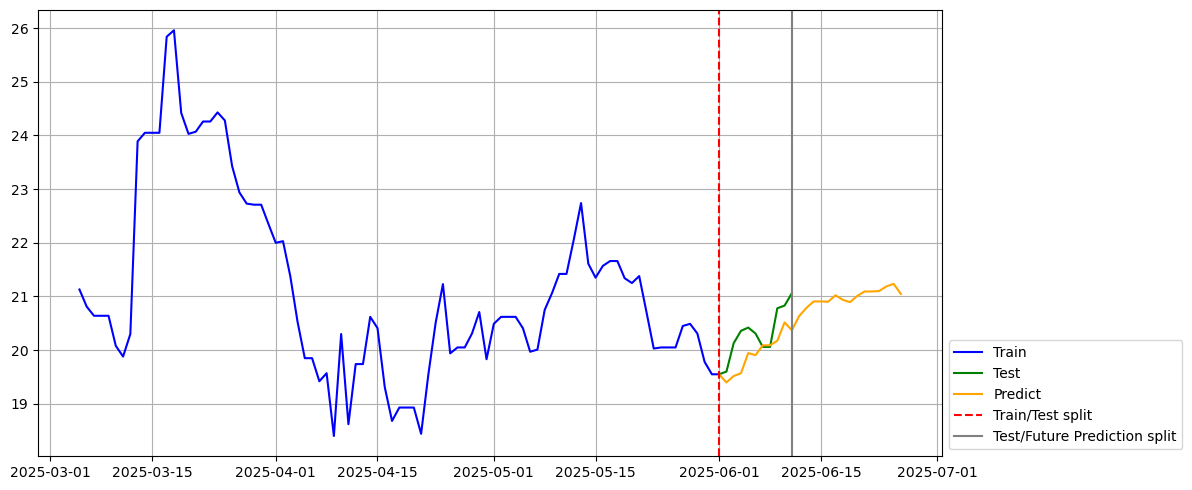

In [15]:
start = len(train)
end = len(train) + len(test) - 1 + 15
predictions = result.predict(start, end).rename("Predictions")

# plot predictions and actual values
prepended_value = pd.Series([train['Current price'].iloc[-1]], index=[train.index[-1]])
test_series = pd.concat([prepended_value, test['Current price']])
predictions = pd.concat([prepended_value, predictions])

plt.figure(figsize=(10, 5))
plt.plot(train['Current price'], marker='', linestyle='-', color = 'blue', label = 'Train')
plt.plot(test_series, marker='', linestyle='-', color = 'green', label = 'Test')
plt.plot(predictions, marker='', linestyle='-', color = 'orange', label = 'Predict')
plt.axvline(x=train.index[-1], color='red', linestyle='--', label='Train/Test split')
plt.axvline(x=test.index[-1], color='gray', linestyle='-', label='Test/Future Prediction split')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

### LSTM

Việc chuẩn hóa giá trị trước mô hình LSTM là cần thiết. Nếu miền giá trị quá lớn, LSTM bỏ qua các đặc trưng nhỏ hơn. 

Giá trị được chuẩn hóa sẽ giúp mô hình hội tụ tốt hơn và tránh bị thiên lệch.

In [16]:
scaler = MinMaxScaler(feature_range=(-3, 3))
series = train['Current price'].values
scaled_series = scaler.fit_transform(series.reshape(-1, 1))

- Xử lý dữ liệu huấn luyện và kiểm tra.
- Ta sẽ cho time_step bằng giá trị nào đó, ví dụ là 7, thì mô hình sẽ học đặc điểm của 7 ngày kế trước để dự đoán cho ngày hiện tại.

In [17]:
def create_dataset(series, time_step=1):
    X, y = [], []
    for i in range(len(series) - time_step):
        X.append(series[i:(i + time_step), 0])
        y.append(series[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 7
X_train, y_train = create_dataset(scaled_series, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Cấu hình cho LSTM. Sau đó, thực hiện việc huấn luyện và quan sát độ lỗi ở tập train qua các epoch.

In [18]:
model = Sequential()
model.add(Input(shape=(7, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
class PrintEvery10Epochs(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            loss = logs.get('loss')
            print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=8, verbose=0, callbacks=[PrintEvery10Epochs()])

Epoch 10, Loss: 0.6933
Epoch 20, Loss: 0.4107
Epoch 30, Loss: 0.3353
Epoch 40, Loss: 0.3110
Epoch 50, Loss: 0.3037
Epoch 60, Loss: 0.2969
Epoch 70, Loss: 0.2754
Epoch 80, Loss: 0.2885
Epoch 90, Loss: 0.2709
Epoch 100, Loss: 0.2713
Epoch 110, Loss: 0.2734
Epoch 120, Loss: 0.2642
Epoch 130, Loss: 0.2474
Epoch 140, Loss: 0.2465
Epoch 150, Loss: 0.2767
Epoch 160, Loss: 0.2521
Epoch 170, Loss: 0.2481
Epoch 180, Loss: 0.2292
Epoch 190, Loss: 0.2084
Epoch 200, Loss: 0.2094


Sử dụng mô hình đã huấn luyện để dự đoán cổ phiếu trong 7 ngày tới.

In [20]:
time_steps = range(2, 15)
min_rmse = 1e9
best_time_step = 0

for t in time_steps:
    series = np.insert(test['Current price'].values, 0, train['Current price'].values[-t:])
    scaled_series = scaler.fit_transform(series.reshape(-1, 1))
    X_test, y_test = create_dataset(scaled_series.reshape(-1, 1), t)

    new_sample = scaled_series[-t:].reshape(1, t)
    X_test = np.concatenate((X_test, new_sample), axis=0)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    forecast = model.predict(X_test)

    new_index = test['Current price'].index.append(
        pd.DatetimeIndex([test['Current price'].index[-1] + pd.Timedelta(days=1)])
    )
    prepended_value = pd.Series([train['Current price'].iloc[-1]], index=[train.index[-1]])
    test_series = pd.concat([prepended_value, test['Current price']])

    forecast = scaler.inverse_transform(forecast)
    forecast_df = pd.DataFrame({'Forecast': forecast.flatten()}, new_index - pd.Timedelta(days=1))

    rmse_value = rmse(test_series, forecast_df['Forecast'])
    if rmse_value < min_rmse:
        min_rmse = rmse_value
        best_time_step = t

print(best_time_step)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
14


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


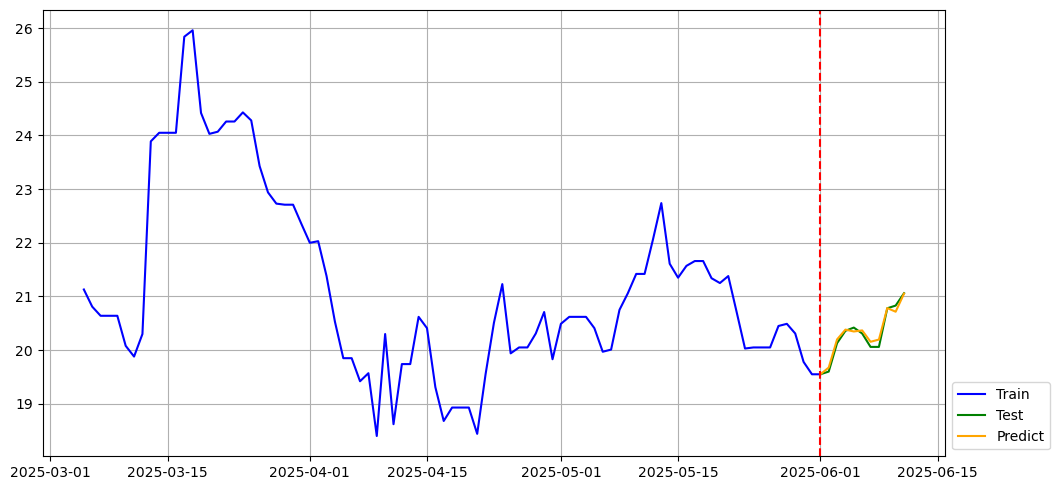

In [21]:
# Forecast future values
time_step = best_time_step
series = np.insert(test['Current price'].values, 0, train['Current price'].values[-best_time_step:])
scaled_series = scaler.fit_transform(series.reshape(-1, 1))
X_test, y_test = create_dataset(scaled_series.reshape(-1, 1), best_time_step)

# Thêm 1 sample mới từ t giá trị cuối
new_sample = scaled_series[-best_time_step:].reshape(1, best_time_step)
X_test = np.concatenate((X_test, new_sample), axis=0)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
forecast = model.predict(X_test)

new_index = test['Current price'].index.append(
    pd.DatetimeIndex([test['Current price'].index[-1] + pd.Timedelta(days=1)])
)
prepended_value = pd.Series([train['Current price'].iloc[-1]], index=[train.index[-1]])
test_series = pd.concat([prepended_value, test['Current price']])


# Inverse transform to original scale
forecast = scaler.inverse_transform(forecast)
forecast[0] = train['Current price'][-1]
forecast_df = pd.DataFrame({'Forecast': forecast.flatten()}, new_index - pd.Timedelta(days=1))
plt.figure(figsize=(10, 5))
plt.plot(train['Current price'], marker='', linestyle='-', color = 'blue', label = 'Train')
plt.plot(test_series, marker='', linestyle='-', color = 'green', label = 'Test')
plt.plot(forecast_df['Forecast'], marker='', linestyle='-', color = 'orange', label = 'Predict')
plt.axvline(x=train.index[-1], color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

Đánh giá độ lỗi RMSE trên tập test.

In [22]:
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse_value = rmse(test_series, forecast_df['Forecast'])
print("Root mean squared error: ", rmse_value)

Root mean squared error:  0.07418263896906299


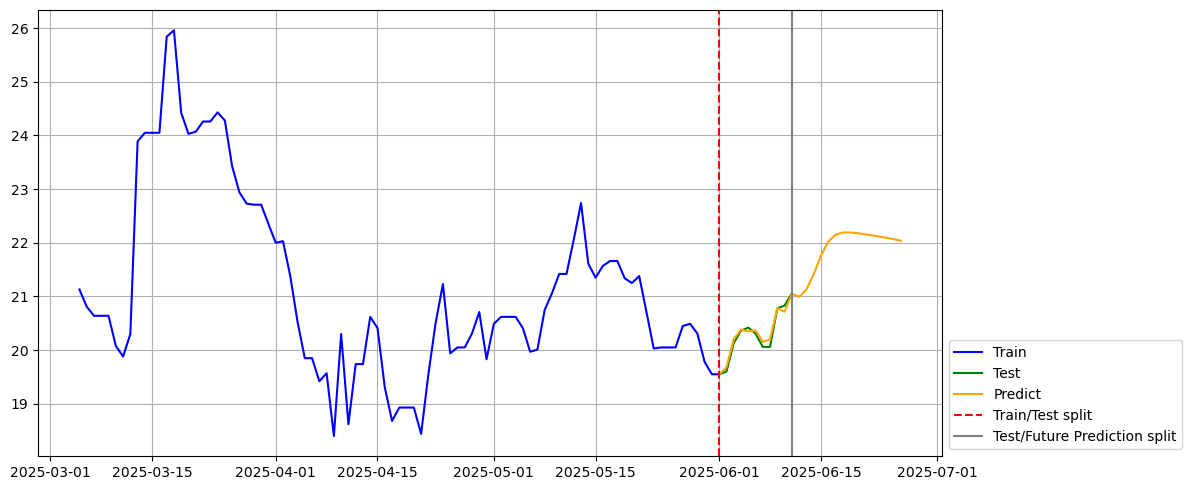

In [23]:
# Forecast future values
time_step = best_time_step
series = np.insert(test['Current price'].values, 0, train['Current price'].values[-best_time_step:])
scaled_series = scaler.fit_transform(series.reshape(-1, 1))
X_test, y_test = create_dataset(scaled_series.reshape(-1, 1), best_time_step)

new_sample = scaled_series[-best_time_step:].reshape(1, best_time_step)
X_test = np.concatenate((X_test, new_sample), axis=0)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
forecast = model.predict(X_test, verbose=0)

new_index = test['Current price'].index.append(
    pd.DatetimeIndex([test['Current price'].index[-1] + pd.Timedelta(days=1)])
)
prepended_value = pd.Series([train['Current price'].iloc[-1]], index=[train.index[-1]])
test_series = pd.concat([prepended_value, test['Current price']])


forecast = scaler.inverse_transform(forecast)
forecast[0] = train['Current price'][-1]
forecast_df = pd.DataFrame({'Forecast': forecast.flatten()}, new_index - pd.Timedelta(days=1))

series = np.insert(forecast_df['Forecast'].values, 0, train['Current price'].values[-best_time_step:-1])
scaled_series = scaler.fit_transform(series.reshape(-1, 1))
for i in range(15):
    X_pred = scaled_series
    X_pred = X_pred.reshape(1, len(scaled_series), 1)
    y_pred = model.predict(X_pred, verbose=0)
    scaled_series = np.append(scaled_series, y_pred)

series_pred = scaler.inverse_transform(scaled_series.reshape(-1,1))
date_range = pd.date_range(start=train['Current price'].iloc[-best_time_step:-1].index[0],
                           periods=len(series_pred), freq='D')
df_pred = pd.DataFrame({'Prediction': series_pred.ravel()}, index=date_range)
df_pred = df_pred[df_pred.index >= forecast_df['Forecast'].index[0]]

plt.figure(figsize=(10, 5))
plt.plot(train['Current price'], marker='', linestyle='-', color = 'blue', label = 'Train')
plt.plot(test_series, marker='', linestyle='-', color = 'green', label = 'Test')
plt.plot(df_pred['Prediction'], marker='', linestyle='-', color = 'orange', label = 'Predict')
plt.axvline(x=train.index[-1], color='red', linestyle='--', label='Train/Test split')
plt.axvline(x=test.index[-1], color='gray', linestyle='-', label='Test/Future Prediction split')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

# Kết luận

Mô hình học sâu LSTM có nhiều tiềm năng để cải thiện độ chính xác trong việc dự đoán dữ liệu dạng time-series, bởi vì nó có sự linh hoạt khi cấu hình đa dạng theo yêu cầu.

# Tham khảo


[ARIMA Model](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)

[Build LSTM Model](https://www.statology.org/how-to-build-lstm-models-for-time-series-prediction-in-python/)